Author: Abdulrahman Altahhan, 2025

The notebook uses a library of functionality in RL that aims for simplicity and general insight into how algorithms work, these libraries are written from scratch using standard Python libraries (numpy, matplotlib etc.).
Please note that you will need permission from the author to use the code for research, commercially or otherwise.

# Worksheet 13- State-Value Approximation Methods for Prediction

**Learning outcomes**

1. understand the intractability of some real-world state space
2. understand state space representation via a set of features and its advantages
3. understand the properties of different function approximation models
4. understand how to generalize tabular on-policy prediction methods to function approximation methods

In this lesson, we deal with function approximation to represent the state. We will use different encoding regimes. One straightforward idea is to represent the whole space as a binary vector, where each entry represents a state. Another idea is to combine multiple entries/components from multiple vectors to represent the state and more. It is a good idea to start by reading section 9.5 of our book.

**Reading**:
The accompanying reading of this lesson is **chapter 9** of our text book available online [here](http://incompleteideas.net/book/RLbook2020.pdf). Please note that we explain the ideas of this topic from a practical perspective and not from a theoretical perspective which is already covered in the textbook.

In [1]:
%matplotlib inline

In [2]:
from rl.rl import *

## State Representation: One-hot Encoding

### Vectorising Grid World with One-hot Encoding

In this section we aim to vectroise the grid world that we developed in the early lessons of a previous unit. The idea is to move gradually away from the tabular representation towards state-value function approximation where we *approximate* each state as a vector of features. Note that we where *estimating* the state-value function in the tabular form. So given that we assume limited states, it is possible, at least in theory to reach an exact value for all state-values or the action-values. When we deal with vector representation of a state, we depart from having finite number of states to the possibility of having infinite number of states in the world. Therefore, in this case we will be *approximating* the state representation and in turn we are *estimating an approximate* state-value and action-value functions and hence the name of our methods are Function Approximation Methods. 

To encode a state, we set to 1 the corresponding component while all other features are set to 0. 

In [3]:
class vGrid(Grid):
    def __init__(self, nF=None, **kw):
        super().__init__( **kw)
        # num of features to encode a state
        self.nF = nF if nF is not None else self.nS 
        self.S = None
        
    # vectorised state representation: one-hot encoding (1 component represents a state)
    def s_(self):
        φ = np.zeros(self.nF)
        φ[self.s] = 1 
        return φ

    def S_(self):
        if self.S is not None: return self.S
        # S is a *matrix* that represents the full state space, this is only needed for Grid visualisation
        sc = self.s  # store current state to be retrieved later
        for self.s in range(self.nS): 
            self.S = np.c_[self.S, self.s_()] if self.s else self.s_()
        self.s = sc 
        return self.S

Note that we need to pass 'vGrid' as the prefix for functions that deals with the different Grid types (such as maze and ranwalk ) to return a vGrid type instead of the usual Grid type in order to get the vectorised state representation that we defined above.

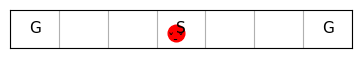

array([0., 0., 0., 1., 0., 0., 0.])

In [4]:
randwalk(vGrid).render()
randwalk(vGrid).s_()

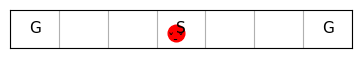

3

In [6]:
randwalk().render()
randwalk().s_()

Compare the return of the above calls, in the vGrid we obtained a vector that represents the current state while in the Grid we get the index of the current state. 

We can also define a vrandwalk to be a vectroised random walk grid as follows.

In [7]:
def vrandwalk(**kw):  return randwalk  (vGrid, **kw)
def vrandwalk_(**kw): return randwalk_ (vGrid, **kw)
def vgrid(**kw):      return grid      (vGrid, **kw)
def vmaze(**kw):      return maze      (vGrid, **kw)
def vcliffwalk(**kw): return cliffwalk (vGrid, **kw)
def vwindy(**kw):     return windy     (vGrid, **kw)

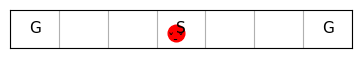

array([0., 0., 0., 1., 0., 0., 0.])

In [8]:
vrandwalk().render()
vrandwalk().s_()

# Prediction with Function Approximation

## MRP with *Linear* Function Approximation

Linear Feature Representation

In a linear model we will devise, customary to linear regression models, a set of weights that correspond with each feature, so we have a weight vector that have the same size of the feature vector along with the bias, we will defer treating the bias to when it becomes necessary.

Because we are dealing with linear models(regardless of the representation), the value function is given as

$V(s) = w^\top x$

The update for the weights parameters will be applied similar to what we did for the tabular but this time we will use the dot product. 

In hot encoding, each component's weight is really the value function for the corresponding state. We should get identical results of those that we obtained for the problems that we tackled in the tabular form, ex. random walk, the maze, the cliff walking etc. 



In [9]:
class vMRP(MRP):
        
    # set up the weights, must be done whenever we train
    def init(self):
        self.w = np.ones(self.env.nF)*self.v0
        self.V = self.V_ # this allows us to use a very similar syntax for our updates
        self.S_= None
        
    #-------------------------------------------buffer related-------------------------------------
    # allocate a suitable buffer
    def allocate(self): 
        super().allocate()
        self.s = np.ones ((self.max_t, self.env.nF), dtype=np.uint32) *(self.env.nS+10)    
    
    #---------------------------------------- retrieve Vs ------------------------------------------
    def V_(self, s=None):
        return self.w.dot(s) if s is not None else self.w.dot(self.env.S_()) 
        
    def ΔV(self,s): # gradient: we should have used ∇ but jupyter does not like it
        return s



Note how we redefined the V as a function instead of as a array which allows us to use a very similar syntax for our updates, we will replace the squared brackets with rounded brackets and that's it!! thanks to the way we originally structured our MRP infrastructure. To appreciate this, let us see how we can redefine our offline MC algorithm along with the online TD update to deal with function approximation. Below we show how.
        

## Gradient MC with Function Approximation

            -∇ Jt = -∇ 1/2(δt^2) = 
            -∇ 1/2(Gt - V(s))^2 = 
            -2(1/2)(Gt - V(s))*(∇ Gt - ∇ V(s)) = 
            -1(Gt - V(s))*(0-s)=
            (Gt - V(s))*s

In [10]:
class MC(vMRP):
    def __init__(self,  **kw):
        super().__init__(**kw)
        self.store = True 
        
    def init(self):
        super().init() # this is needed to bring w to the scope of the child class
        self.store = True 
        
    # ----------------------------- 🌘 offline, MC learning: end-of-episode learning ----------------------    
    def offline(self):
        # obtain the return for the latest episode
        Gt = 0
        for t in range(self.t, -1, -1):
            s = self.s[t]
            rn = self.r[t+1]
            
            Gt = self.γ*Gt + rn
            self.w += self.α*(Gt - self.V(s))*self.ΔV(s)


This definition is almost identical to the tabular definition except for the following:
1. we update now a set of weights instead of one entry in a table. So in the left hand side we see w instead of V[s].
2. we use V(.) instead of V[.] on the right hand side (we could have used operator overloading to keep using the [.] but it is a bit more involving) 
3. we multiply by the gradient ∇V(s) that is given by the MRP parent class.

Note that s here is the state representation of the actual state, i.e. it is a vector of components.

Note also that although the parent class deals with linear function approximation, the MC class does not assume that, it just needs the gradient of the V. So, as along as we make sure the parent MRP class does provide this function, we can define other types of MRP that use other types of function approximation like the tile coding or neural networks and we would not need to change the TD definition. 
Please refer to section 9.3 of the book for more details.

Let us now apply this vectorised from of the MC, or more precisely the gradient MC algorithm, on the random walk problem that use one-hot encoding. 

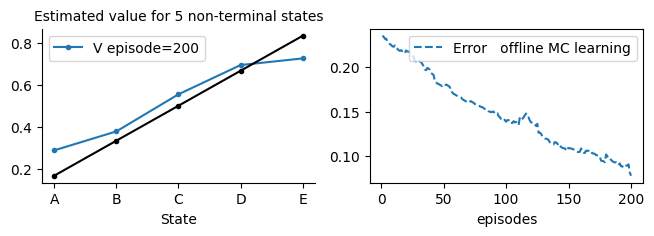

In [14]:
mcwalk = MC(env=vrandwalk(), α=.005, episodes=200, v0=.5, seed=0, **demoV()).interact(label='offline MC learning')

## Online Semi-Gradient TD with Linear Function Approximation

In [16]:
class TD(vMRP):
    # ----------------------------- 🌖 online learning ----------------------    
    def online(self, s, rn,sn, done, *args): 
        self.w += self.α*(rn + (1-done)*self.γ*self.V(sn) - self.V(s))*self.ΔV(s)

Again, note also that although the parent class deals with linear function approximation, the TD class does not assume that, it just needs the gradient of V. So, as along as we make sure the parent MRP class does provide this function, we can define other types of MRP that use other types of function approximation like the tile coding or neural networks and we would not need to change the TD definition. Therefore we can use a class factory to be able to change the parent class when we need to.

We called this algorithmm a semi-gradient since we took the gradient of the value function V(s) and not the gradient of the target V(sn). The reason is to do be consistent with MC which is considered the theoretical baseline for TD. Nevertheless, there are algorithms that takes the gradient of both, although these are usually not as fast as semi-gradient TD, especially with linear function approximation, refer to section 9.3 of our book for more details.

Let us now apply this vectorised from of the TD, or more precisely the semi-gradient TD algorithm. We call it semi-gradient because we to the gradient of one of the terms of TD error which is the estimation of the current state and we left the target estimation of the next state as is. Please refer to section 9.3 of the book.

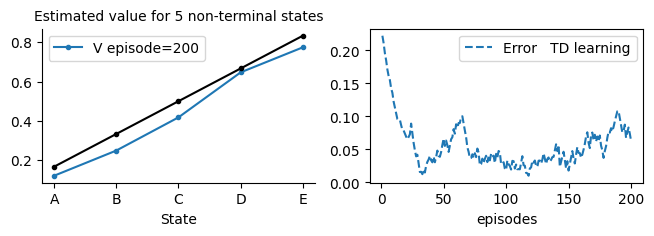

In [18]:
TDwalk = TD(env=vrandwalk(), episodes=200, v0=.5, **demoV()).interact(label='TD learning')

We need to pass the env explicitly because we have inherited the MRP and the new environment would have no took effect.

## Offline Semi-Gradient TD with Function Approximation

In [19]:
class TDf(vMRP):
    
    def init(self):
        super().init()
        self.store = True
        
    # ----------------------------- 🌘 offline TD learning ----------------------------   
    def offline(self):
        for t in range(self.t, -1, -1):
            s = self.s[t]
            sn = self.s[t+1]
            rn = self.r[t+1]
            done = self.done[t+1]
            
            self.w += self.α*(rn + (1-done)*self.γ*self.V(sn) - self.V(s))*self.ΔV(s)


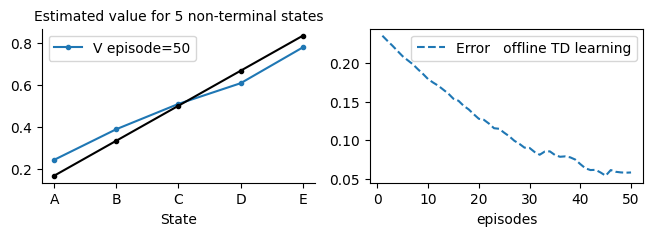

In [20]:
tdwalk = TDf(env=vrandwalk(), α=.05, episodes=50, v0=.5, **demoV()).interact(label='offline TD learning')

Let us rerun example 6.2 to double check that our algorithm is working well. This time we are using a vectorised grid and a linear model for TD and MC.

100%|██████████████████████████████████████████████████████████████████████████████████████████|100/100
100%|██████████████████████████████████████████████████████████████████████████████████████████|100/100
100%|██████████████████████████████████████████████████████████████████████████████████████████|100/100
100%|██████████████████████████████████████████████████████████████████████████████████████████|100/100
100%|██████████████████████████████████████████████████████████████████████████████████████████|100/100
100%|██████████████████████████████████████████████████████████████████████████████████████████|100/100
100%|██████████████████████████████████████████████████████████████████████████████████████████|100/100


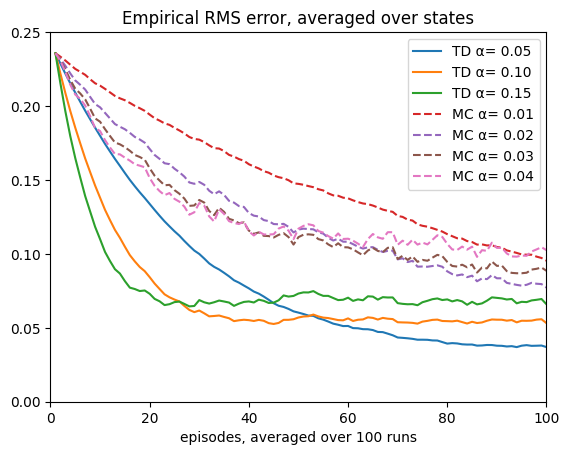

In [21]:
# runing the book example 6.2 which compare TD and MC on randome walk, but this time we use vector representation
example_6_2(env=vrandwalk(), alg1=TDf, alg2=MC)

##  One-hot-encoding with redundant features for prediction
As an auxiliary step towards generalising our classes to deal with any linear function approximation, below we create a random walk problem with 1000 redundant features to test whether our infrastructure classes are working.

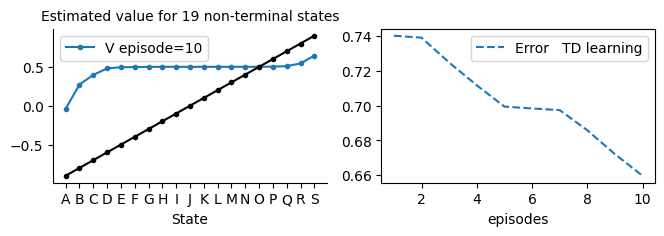

In [22]:
vTDwalk = TD(env=vrandwalk_(nF=100), episodes=10, v0=.5, seed=10, **demoV()).interact(label='TD learning')

## State Representation: State aggregation


$\underbrace{\{s_0\}}_{F_0}, \underbrace{\{s_1, s_2, ..., s_{100}\}}_{F_1}, \underbrace{\{s_{101}, s_{102}, ..., s_{200}\}}_{F_2},...,  \underbrace{\{s_{901}, s_{902}, ..., s_{1000}\}}_{F_{10}}, \underbrace{\{s_{1001}\}}_{F_{11}},$


For the state aggregation to work as intended, the goals must have a separate state representation from the groups; hence we dedicate the first and the last components for these two terminal states as we have shown above (or even put both of them in the same component). We then divide the non-goal states into 100, where each 100 are represented via a component and whenever the agent is at any of the 100 states the corresponding component will be on and all other components are off. 


Let us now move to a different state representation technique that generalizes the simple state-to-component one-hot encoding regime that we used earlier. We would like to move closer toward bridging continuous and discrete state space and so aggregation seems an obvious choice. In state aggregation, we group a set of states together and represent them all in one component(feature) and we use again one-hot encoding. This time one component represents a group of states instead of one state. Therefore, we turn a component(feature) on whenever the agent is at *any* of the group of states that corresponds to it. 

$F_i: \underbrace{\{s_0, s_1, ..., s_{99}\}}_{F_0}, \underbrace{\{s_{100}, ..., s_{199}\}}_{F_1},...,  \underbrace{\{s_{900}, ..., s_{999}\}}_{F_9}$


Therefore, if the agent is in state $s_{100}$, in state $s_{199}$ or in any state in between, the feature $F_1$ will be on = 1 and the rest $F_0, F_2...F_9$ are all $0$'s. The feature vector that represents the current state would be $F =[0,1,0,0,0,0,0,0,0,0]$

This way also we treat the goal(terminal) states like other non-terminal states in terms of representation, and that is ok since we will leave the terminal state treatment to the learning algorithms. Recall that the *return* at time step $t$ is the sum of expected *future* rewards from time step $t+1$ to the end of an episode at time step $T$ and is given by:  

$G_t = R_{t+1} + R_{t+2} + ... + R_{T}$

So the *reward* of current state does not participate in its *return* unlike the rewards of all future rewards that form the current state return. Hence the *terminal state value* (or expected return) is always set to 0 because the agent stays there and it will not obtain any *future* rewards from that state on. This is different than the *terminal state reward* itself given by the environment which may or may not be 0. Our algorithms do the following to treat terminal states: when the next state s' is a terminal state all of our algorithms will assign 0 to the terminal state's value estimation by multiplying it by (1-done), done is True on terminal state so (1-done)=0 at the terminal state. This alleviate us from having to designate a separate component to represent the terminal states and simplifies greatly our implementation.

We call each group a tile, so a tile covers a group of states, think of a state in this context as the unit that we measure the tile's area with (hence the bridging of continuous and discrete state space). The above example has 10 tiles each of size 100 sates, while using tiles of size 200 mean that each covers or encompasses 200 states and will result in a feature vector of 5 components. 

Similar to vectors and matrices, tiles comes in different dimensions. When we deal with random walk problems we have 1-d tiles, while when we deal with a usual grid we will be dealing with 2-d tiles. The tile(group) size is stored in a variable called **tilesize**. Refer to example 9.2 in the book for more details. 

Below we provided an explanation of a precise process that we can use to achieve the above representation. 

In [17]:
15//3

5

In [18]:
nS = 1002
nS = 900
goals = [0, nS-1]
tilesize = 200

#------------calculating number of componenets(features)-----------
nF =  -(-nS//tilesize)   # 1 in case of nS is not divisible by tilesize
print('number of groups = ', nF)

#------------obtainng an index (feature)---------------------------
s   =  100# goals[1] # goals[0]
ind =  s//tilesize
print('the goal\'s index = ', ind)

#------------assigning the feature---------------------------------
w = np.zeros(nF)
w[ind] = 1
print(w)

number of groups =  5
the goal's index =  0
[1. 0. 0. 0. 0.]


In [19]:
#In python the operator // rounds up if we used a negative number
print(   1002//200 )
print(-(-1002//200))

5
6


In [23]:
class aggGrid(vGrid):
    def __init__(self, tilesize=1, **kw):
        super().__init__(**kw)
        self.tilesize = self.jump = tilesize
        self.nF = -(-self.nS//self.tilesize)
        
    def s_(self):
        φ = np.zeros(self.nF) 
        φ[self.s//self.tilesize] = 1 
        return φ

As we can see, we have encoded the states via our s_( ) function which uses one-hot encoding. 
The index is specified via the aggregation which is achieved by using the //tilesize operation.

### 1000 states random walk with jumps

To shorten the time of transfer between the states and to adapt it to work well with state aggregation we inherited from the class vGrid which inherited from Grid, which in turn allows the agent to jump any number of states. vGrid also provide access to S_() function which is needed to obtain the V_ values of the random walk process.

In the example below we choose to allow for a random jumps of up to 50 steps and we aggregate/group the states into 50 instead of 100 because this will result in around 20 feature similar to our 19-state random walk problem that we saw earlier in previous lessons (it is 19+2 states with terminal states).


$\underbrace{\{s_0, s_1, ..., s_{49}\}}_{F_0}, \underbrace{\{s_{50}, ..., s_{99}\}}_{F_1},...,  \underbrace{\{s_{950}, ..., s_{999}\}}_{F_{19}}$

In [24]:
# assuming that vstar is a function that returns Vstar values
def aggrandwalk_(nS=1000, tilesize=50, vstar=None, **kw): 
    env = randwalk_(aggGrid, nS=nS, tilesize=tilesize, **kw)
    if vstar is not None: env.Vstar = vstar(env) # vstar is a function
    return env

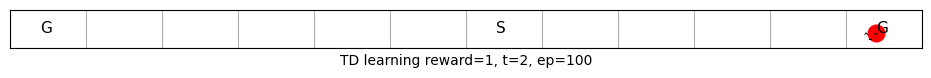

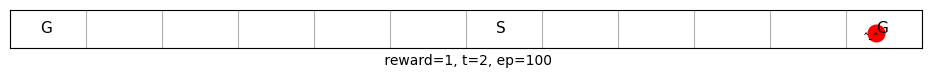

In [25]:
aggTDwalk = TD(env=aggrandwalk_(nS=12, tilesize=4, figsize=[40,.5], jump=4), 
                 episodes=100, v0=.5, seed=10, visual=True).interact(label='TD learning', pause=.5)

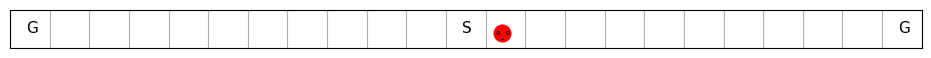

In [26]:
env = aggrandwalk_(nS=23, tilesize=3, figsize=[40,.5])
env.render(pause=1)
env.jump=3
env.step(1)
env.render()

Let us now apply our online TD on a 25 state aggregation problem with 5 groups.

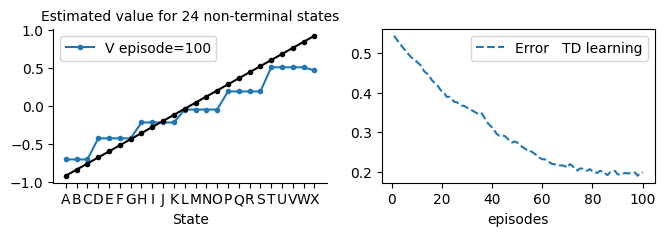

In [27]:
aggTDwalk = TD(env=aggrandwalk_(nS=24+2, tilesize=4),α=.05, episodes=100, v0=.0, seed=10, **demoV()).interact(label='TD learning')

## n-step TD with linear function approximation

In [28]:
class TDn(vMRP):

    def init(self):
        super().init()
        self.store = True # there is a way to save storage by using t%(self.n+1) but we left it for clarity

    # ----------------------------- 🌖 online learning ----------------------    
    def online(self,*args):
        τ = self.t - (self.n-1);  n=self.n
        if τ<0: return
        
        # we take the min so that we do not exceed the episode limit (last step+1)
        τn = τ+n ; τn=min(τn, self.t+1 - self.skipstep)
        τ1 = τ+1
        
        sτ = self.s[τ ]
        sn = self.s[τn]
        done = self.done[τn]
        
        # n steps τ+1,..., τ+n inclusive of both ends
        self.w += self.α*(self.G(τ1,τn)+ (1-done)*self.γ**n *self.V(sn) - self.V(sτ))*self.ΔV(sτ)
        


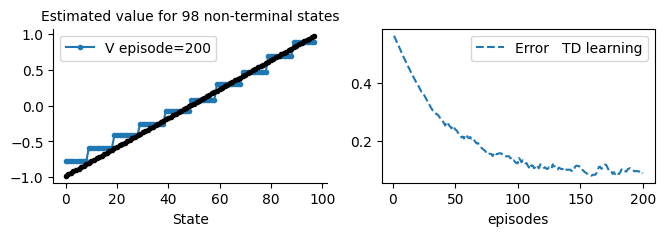

In [30]:
# try increase nS to 102+2 to see the effect
aggTDwalk = TDn(env=aggrandwalk_(nS=100, tilesize=10), α=.02, n=4, episodes=200, v0=.0, seed=10, **demoV()).interact(label='TD learning')

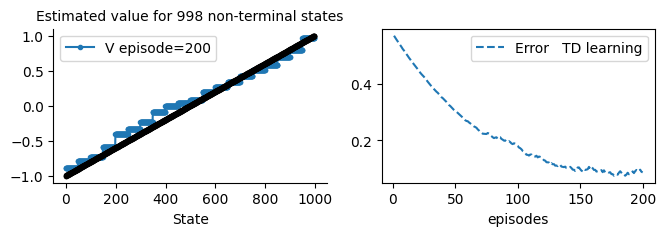

In [31]:
aggTDwalk = TDn(env=aggrandwalk_(), α=.01, n=10, episodes=200, v0=.0, seed=0, **demoV()).interact(label='TD learning')

Note that we had to reduce the learning rate α because the increased number of steps entails more updates and hence larger update magnitude.

## Solving the 1000 Random Walk via Dynamic Programming(DP)

It might be hard to notice that the stairs looks a bit off (bottom steps start over the straight line and top ones appears under the line). The problem is in fact not in our TDn algorithm, instead it is in the Vstar solution (the straight line). Because we add the ability for the agent to jump, the old solution is not valid any more albeit very close.

To arrive to a more accurate solution, we can hand in the problem to a dynamic programming algorithm to solve it for us. Below we show a solution for the 1000 random walk with jumps based on Dynamic Programming techniques that we covered in lesson 3. Particularly we use the policy evaluation method since we are dealing with prediction and the policy is stationary (agent moves either to the left or to the right with equal .5 probabilities.)

DP will help us to see how far the initial guess (the one similar to 19-states but with 1000 states random walk *without* the jumps) from the actual solution of the 1000-states random walk with the jumps. 

In [32]:
def DP(env=aggrandwalk_(), compare=False, θ=1e-2):
    π = np.ones((env.nS, env.nA), dtype=np.uint32)*.5
    Vstar = Policy_evaluation(env=env, π=π, V0=env.Vstar, θ=θ, show=False)
    print('V* obtained')
    if compare:
        plt.plot(env.Vstar,   label='solution for 1000-random walk without jumps')
        plt.plot(Vstar[1:-1], label='solution for 1000-random walk with    jumps')
        plt.legend()
    return Vstar

Let us compare the default straight line solution to the V* solution for the random walk problem when we employ the jumping procedure. This will take a couple of minutes so please wait for it.

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.83it/s]


V* obtained


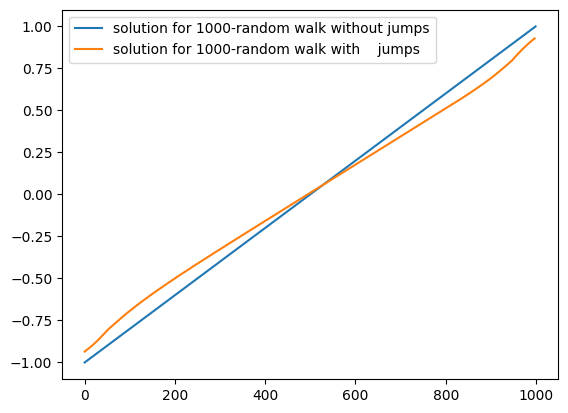

In [33]:
aggVstar = DP(env=aggrandwalk_(), compare=True)

This shows that the initial guess and the DP solution are close but not quite the same. Note that if we decrease θ the algorithm will get a more accurate estimation (the blue line will bend further) but it will take longer to run, the length of the run shows one of the issues of DP compared to more resilient and faster RL algorithms such as TD. Trye set  θ=1e-3 to see how long it will take and share the length within the group discussion.

## Solving the 1000 Random Walk with Online n-step TD with linear function approximation and state aggregation

We can integrate finding a DP solution with the comparison as below, but since we have already found a solution in the previous steps we can simply also utilise the solution for comparison directly as we do in subsequent cells. Note that the level of accuracy, specified in θ, can be adjusted. 

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.80it/s]


V* obtained
100%|██████████████████████████████████████████████████████████████████████████████████████████|32/32
100%|██████████████████████████████████████████████████████████████████████████████████████████|32/32
100%|██████████████████████████████████████████████████████████████████████████████████████████|32/32
100%|██████████████████████████████████████████████████████████████████████████████████████████|32/32
100%|██████████████████████████████████████████████████████████████████████████████████████████|32/32
100%|██████████████████████████████████████████████████████████████████████████████████████████|32/32
100%|██████████████████████████████████████████████████████████████████████████████████████████|32/32
100%|██████████████████████████████████████████████████████████████████████████████████████████|32/32
100%|██████████████████████████████████████████████████████████████████████████████████████████|32/32
100%|█████████████████████████████████████████████████████████████████

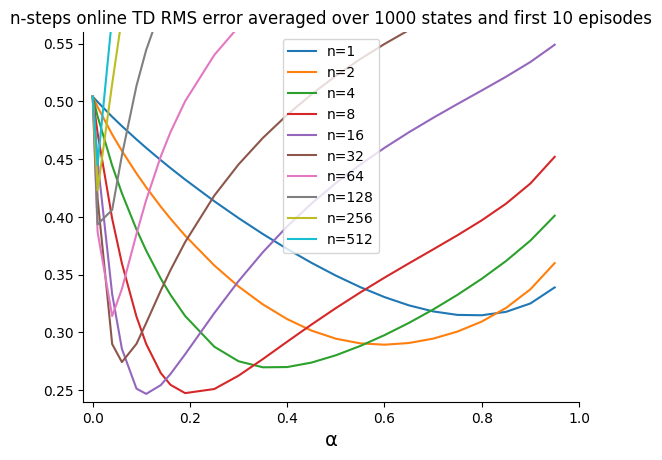

In [34]:
%time nstepTD_MC_randwalk_αcompare(env=aggrandwalk_(vstar=DP), \
                                   algorithm=TDn, runs=10, envlabel='1000', MCshow=False)

100%|██████████████████████████████████████████████████████████████████████████████████████████|32/32
100%|██████████████████████████████████████████████████████████████████████████████████████████|32/32
100%|██████████████████████████████████████████████████████████████████████████████████████████|32/32
100%|██████████████████████████████████████████████████████████████████████████████████████████|32/32
100%|██████████████████████████████████████████████████████████████████████████████████████████|32/32
100%|██████████████████████████████████████████████████████████████████████████████████████████|32/32
100%|██████████████████████████████████████████████████████████████████████████████████████████|32/32
100%|██████████████████████████████████████████████████████████████████████████████████████████|32/32
100%|██████████████████████████████████████████████████████████████████████████████████████████|32/32
100%|█████████████████████████████████████████████████████████████████████████████

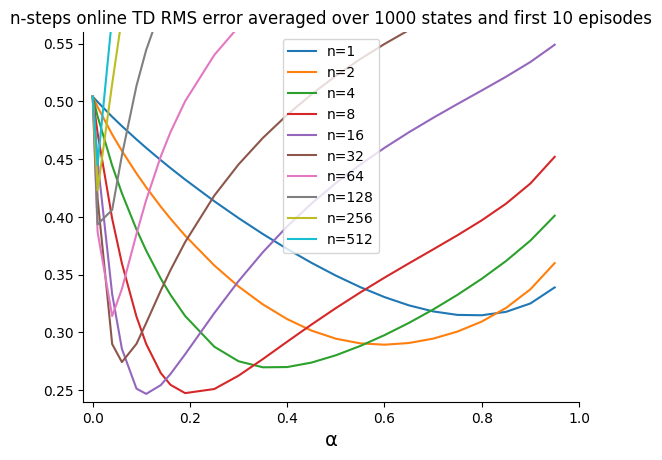

In [35]:
%time nstepTD_MC_randwalk_αcompare(env=aggrandwalk_(Vstar=aggVstar), \
                                   algorithm=TDn, runs=10, envlabel='1000', MCshow=False)

## Offline n-step TD with linear function approximation

In [36]:
class TDnf(vMRP):

    def init(self):
        super().init()
        self.store = True # offline method we need to store anyway

    # ----------------------------- 🌘 offline TD learning ----------------------------   
    def offline(self):
        n=self.n        
        for t in range(self.t+n): # T+n to reach T+n-1
            τ  = t - (n-1)
            if τ<0: continue
        
            # we take the min so that we do not exceed the episode limit (last step+1)
            τ1 = τ+1
            τn = τ+n ; τn=min(τn, self.t+1)
            
            sτ = self.s[τ ]
            sn = self.s[τn]
            done = self.done[τn]
            
            # n steps τ+1,..., τ+n inclusive of both ends
            self.w += self.α*(self.G(τ1,τn)+ (1-done)*self.γ**n *self.V(sn) - self.V(sτ))*self.ΔV(sτ)

## Solving the 1000 with Offline n-step TD with linear function approximation and state aggregation

100%|██████████████████████████████████████████████████████████████████████████████████████████|32/32
100%|██████████████████████████████████████████████████████████████████████████████████████████|32/32
100%|██████████████████████████████████████████████████████████████████████████████████████████|32/32
100%|██████████████████████████████████████████████████████████████████████████████████████████|32/32
100%|██████████████████████████████████████████████████████████████████████████████████████████|32/32
100%|██████████████████████████████████████████████████████████████████████████████████████████|32/32
100%|██████████████████████████████████████████████████████████████████████████████████████████|32/32
100%|██████████████████████████████████████████████████████████████████████████████████████████|32/32
100%|██████████████████████████████████████████████████████████████████████████████████████████|32/32


C:\Users\bryar\AppData\Local\Temp\ipykernel_34948\3845626547.py:23: RuntimeWarning: invalid value encountered in multiply
  self.w += self.α*(self.G(τ1,τn)+ (1-done)*self.γ**n *self.V(sn) - self.V(sτ))*self.ΔV(sτ)


100%|██████████████████████████████████████████████████████████████████████████████████████████|32/32
CPU times: total: 2min 37s
Wall time: 2min 38s


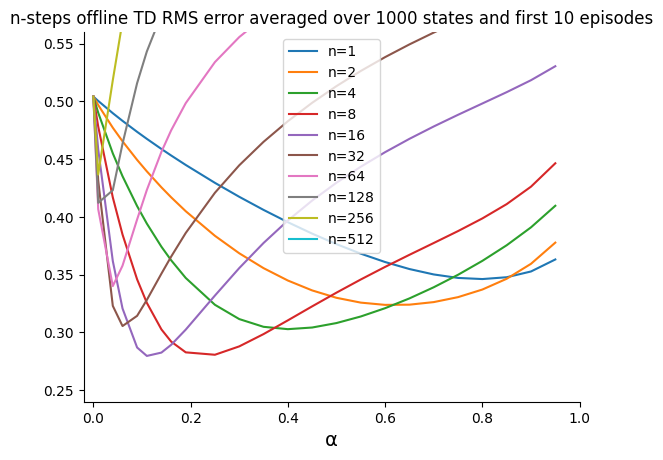

In [37]:
%time nstepTD_MC_randwalk_αcompare(env=aggrandwalk_(Vstar=aggVstar),\
                                   algorithm=TDnf, runs=10, alglabel='offline TD', envlabel='1000', MCshow=False)

## State Representation: Tile Coding

Tile coding is a powerful state representation, it takes the idea of state aggregation one step ahead. It is assumed that the state space is *continuous* and we aim to discretize it by partitioning it *several* times. In state aggregation that is what we have done. Effectively we have partitioned the state space into tiles. Here, we will do it for more than 1 time. 

We call each state partition that covers a specific area of the space as a *tiling* and we have $d$ tilings. Each tiling has $n$ tiles as we saw earlier in state aggregation. Each component of a tiling vector is called a *tile*.  The length of the tile encoding vector is $d\times n$.

Therefore, instead of having one component on as in the state aggregation, we design a larger vector where we have more components that are turned on to help us differentiate further between the states. Note that the early grouping that we did in the previous section is actually a tile encoding with *one tiling*.

When an agent is in state $s$ we will have exactly $d$ components turned on and the rest $d\times n - d = d \times (n-1)$ are $0$s (while in state aggregation we had $1$ component on and the rest of the $n-1$ components were $0$).
What is left is to understand how to construct and turn these $d$ components on. For construction we simply look at the state space and cover it with a set of tiles (tiling) so that when an agent in a state, one of the tiles will be on. This can be simply a state partitioning. Then we lay another tiling, this time we shift (or offset/stride similar to what we do in CNN!) them so that there is some level of overlapping between the two tiling and so on. When we have two tilings, we will have two tiles on.


$\underbrace{\{s_0, s_1, ..., s_{199}\}}_{F_{0,0}}, \underbrace{\{s_{200}, ..., s_{399}\}}_{F_{1,0}},...,  \underbrace{\{s_{800}, ..., s_{999}\}}_{F_{4,0}}$

$\underbrace{\{s_1, s_2, ..., s_{200}\}}_{F_{0,1}}, \underbrace{\{s_{201}, ..., s_{400}\}}_{F_{1,1}},...,  \underbrace{\{s_{801}, ..., s_{999}\}}_{F_{4,1}}$

$\underbrace{\{s_2, s_3, ..., s_{201}\}}_{F_{0,2}}, \underbrace{\{s_{202}, ..., s_{401}\}}_{F_{1,2}},...,  \underbrace{\{s_{802}, ..., s_{999}\}}_{F_{4,2}}$

So if the agent in stat $s_{200}$ then its state tile coding representation would be:

$F = [0, 1, 0, 0, 0, \quad 1, 0, 0, 0, 0, \quad 1, 0, 0, 0, 0] $

Finally, if the tiling creates a strain on the memory requirement, we combine it with *hashing*. Hashing can save us lots of space and computation time. Note that when we use hashing we would need to construct a state vector that is of the size of the hashed features which is smaller than that of a $d\times n$ .
Note that although we assumed that the state space is continuous, we can usually *treat* the state space as if it is continuous. See section 9.4.5 along with 9.4.4.




In [38]:
class tiledGrid(vGrid):
    def __init__(self, ntilings, offset=4, tilesize=50, **kw):
        super().__init__(**kw)
        self.tilesize = self.jump = tilesize
        self.ntilings = ntilings
        self.offset = offset
        self.ntiles = -(-self.nS//self.tilesize) 
        self.nF = self.ntiles*self.ntilings
    
    def s_(self):
        φ = np.zeros((self.ntilings, self.ntiles))
        
        for tiling in range(self.ntilings):
            ind = min((self.s + tiling*self.offset)//self.tilesize, self.ntiles-1)
            φ[tiling, ind] = 1
            
        return φ.flatten()

Let us now define a tiled random walk environment with 1000 states handy to be used in our next set of experiments. As usual it has a rewards of (-1,1) for the far left and far right states while it has a tile size of 200. We can use multiple tilings for it to cover its states. We will use our original guess as the optimal Vstar estimation for the state values,however we will allow Vstar to be assigned a more correct values based on DP.

In [39]:
def tiledrandwalk_(nS=1000, ntilings=1, tilesize=200, vstar=None, **kw):
    env = randwalk_(tiledGrid, nS=nS, ntilings=ntilings, tilesize=tilesize,  **kw)
    if vstar is not None: env.Vstar = vstar(env) 
    return env
    #return randwalk_(tiledGrid, nS=nS, Vstar=Vstar, ntilings=ntilings, tilesize=tilesize,  **kw)

### Studying the Effect of Number of Tilings
Below we run the tiled random walk problem with different number of tilings to show there effect.

In [42]:
def TDtiledwalk(ntilings):
    env=tiledrandwalk_(nS=20, tilesize=4, offset=1, ntilings=ntilings)
    TD(env=env, α=.02, episodes=200, **demoV()).interact(label='TD learning, %d tilings'%ntilings)

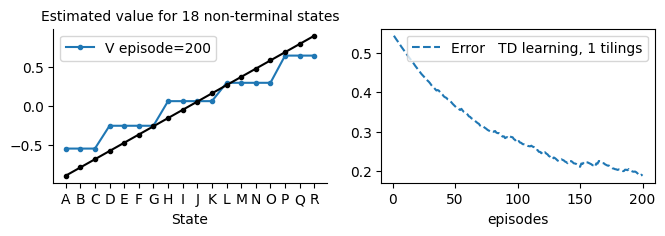

In [43]:
TDtiledwalk(ntilings=1)

TDtiledwalk(ntilings=2)

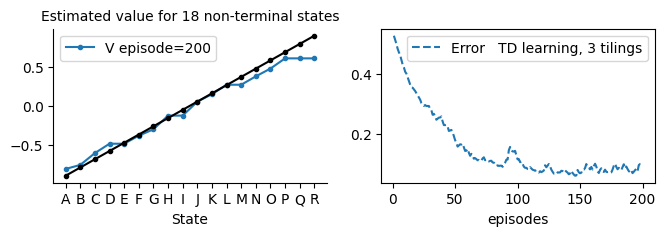

In [44]:
TDtiledwalk(ntilings=3)

TDtiledwalk(ntilings=4)

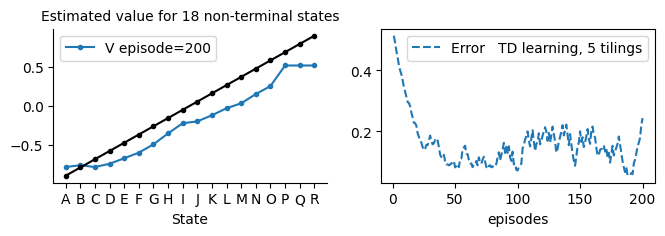

In [45]:
TDtiledwalk(ntilings=5)

Note how the increased number of tilings enhanced the estimation and reduced the error and the values become smoother with less stair-style effect. So in fact ntilings has a smoothening effect on the value function and helps to improve the estimation of our algorithms. 

### TD on 1000 Tiled Coded Random Walk

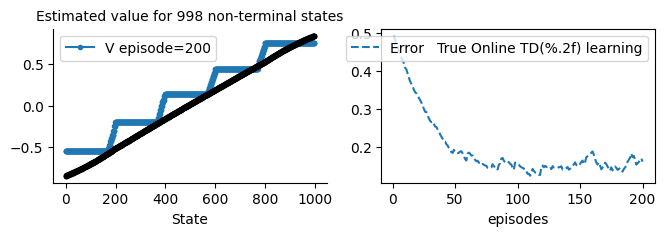

In [46]:
TDwalk = TD(env=tiledrandwalk_(ntilings=8, Vstar=DP(tiledrandwalk_())),α=.005, episodes=200, **demoV()).interact(label='True Online TD(%.2f) learning')

When using function approximation, the objective function needs to be differentiable and we used the sum of squared error (SE) from which we obtained the gradient. This makes sense since it is easily differentiable objective function instead of the harder RMSE (root of the mean squared error). However we can still use our RMSE to measure the performance as we did in previous lesson that we have used previously. 


Below we compare between 1 tiling and 50 tilings for the tiled random walk problem to generate figure 9.10 of the book. We used Monte Carlo because it is a full gradient algorithm since the target does not involve a next step estimate, but we can use TD as well.

First let us find the Vstar for a 200 jumps problem (the previous one was for 50 so we cannot use it).

In [47]:
def MCtiltingsRuns():
    Vstar=DP(tiledrandwalk_(),θ=1e-3)
    for ntilings in [1, 50]:
        env=tiledrandwalk_(ntilings=ntilings, tilesize=200, Vstar=Vstar)
        α =.001/ntilings
        mcs = Runs(algorithm=MC(env=env,α=α, episodes=5000), v0=0, 
                   runs=30, plotE=True).interact(label='MC with %d tilings'%ntilings)
    plt.ylim(0,.45)

figure_9_10=MCtiltingsRuns 

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.05s/it]


V* obtained
100%|██████████████████████████████████████████████████████████████████████████████████████████|30/30
100%|██████████████████████████████████████████████████████████████████████████████████████████|30/30


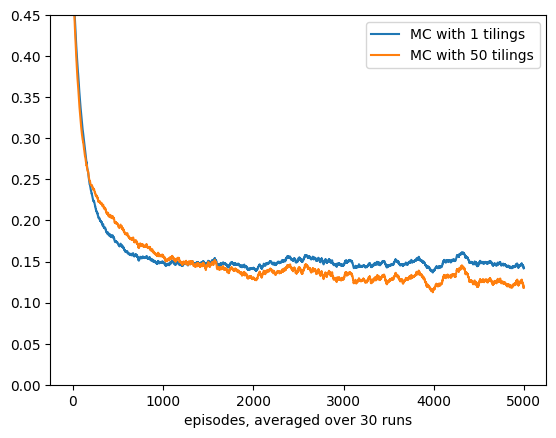

In [48]:
figure_9_10()

This figure takes a long time to produce due to the extensivity of the experiments. As we can see, adding more tilings further reduced the error of the value function estimation and hence enhanced the algorithm's performance.

## Conclusion
In this lesson we have covered the different aspects of using function approximation in the context of reinforcement learning methods We have seen how to generalize the ideas covered in previous lessons to parametric models via semi-gradient methods including Semi-gradient Sarsa.

# Unit's conclusion
This lesson concludes our unit where we have studied important formulation of RL which assumed that we use a parametric representation for our state space using function approximation instead of a table. In the next unit, we continue on that front to cover control algorithms that use function approximation and we will see a set of applications of RL in various domains.


## Your turn
1. Use tile coding on a grid world problem with Sarsa and see its effect.
1. Sutton referred to idea of tile coding and that it is almost trivial to update the weights and rather than doing the dot product we can just pick the components that are active and update accordingly. Can you think of a way to implement such strategy for the state aggregation case? what kind of update we will end up with?
1. When we varies ntilings in TDtiledwalk() function we more fluctuate in the error. Can you think of ways to counter this undesirable effect.
1. In TDtiledwalk() try to reduce the learning rate $\alpha$ when we increase ntilings ex.: $\alpha$=.02/ntilings. Adjust the code and see its effect.
1. Prove the above state form of equation 13.9.
1. Have a look at the following code and see if this implementation for aggGrid makes any difference to the random walk results obtained earlier. Note how this divides the non-terminal states by subtracting the 2 goal states form the count to define nF and then to obtain the hot-encoding it tests whether the state is a goal state and it always subtract 1.  $ i = (s-1)//200$ gives $F_i: \underbrace{\{s_1, s_2, ..., s_{200}\}}_{F_0}, \underbrace{\{s_{201}, ..., s_{400}\}}_{F_1},...,  \underbrace{\{s_{801}, ..., s_{1000}\}}_{F_4}, \underbrace{\{s_{1001}, s_0\}}_{F_5}$. This implementation is more complicated but it will show us a more uniformed division for the non-terminal states. Note that you would need to add 2 also to the nS in randwalk_() so that you can visually see the desired effect of evenly dividing the non-terminal states equally.

[Back to TOC](IntroductionTOC.ipynb)